In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

In [37]:
model_name = "rnnv6EURtoPLN"

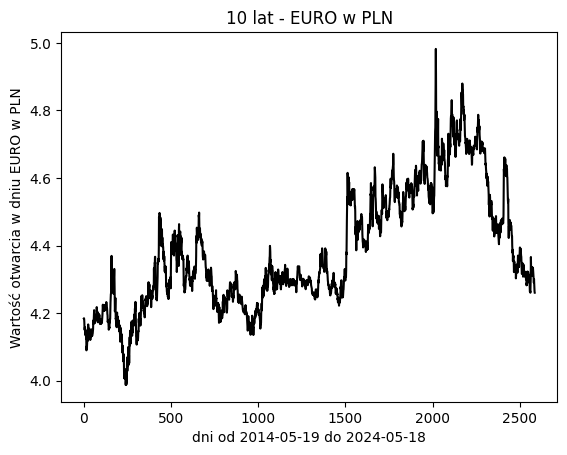

In [38]:
# Wczytanie danych z pliku CSV
# Upewnij się, że ścieżka do pliku jest poprawna
input_data = 'eurpln_d.csv'
df = pd.read_csv(input_data)
# Tworzenie X (liczba porządkowa) i y (wartość otwarcia)
X = np.arange(len(df)).reshape(-1, 1)
y = df['Otwarcie'].values
# Wyświetlenie danych
plt.plot(X, y, color='black', label='Data')
plt.xlabel('dni od 2014-05-19 do 2024-05-18')
plt.ylabel('Wartość otwarcia w dniu EURO w PLN')
plt.title('10 lat - EURO w PLN')
plt.savefig(f'data_{model_name}.png')
plt.show()
# Przeskalowanie wartości y do zakresu od 0 do 1
min_y = np.min(y)
max_y = np.max(y)
y = (y - min_y) / (max_y - min_y)

In [39]:
# Funkcja do przygotowania sekwencji danych
def create_sequences(y_data, seq_length):
    X_sequences = []
    y_labels = []
    for i in range(len(y_data) - seq_length):
        X_sequences.append(y_data[i:i+seq_length])
        y_labels.append(y_data[i+seq_length])
    return np.array(X_sequences), np.array(y_labels)

In [40]:
# Długość sekwencji
seq_length = 50

In [41]:
# Tworzenie sekwencji
X_seq, y_seq = create_sequences(y, seq_length)
print(f'Kształt X_seq: {X_seq.shape}, Kształt y_seq: {y_seq.shape}')

Kształt X_seq: (2536, 50), Kształt y_seq: (2536,)


In [42]:
# Podział danych na zbiór treningowy i testowy
split_index = round(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]
print(f'Kształt X_train: {X_train.shape}, Kształt y_train: {y_train.shape}')
print(f'Kształt X_test: {X_test.shape}, Kształt y_test: {y_test.shape}')

Kształt X_train: (2029, 50), Kształt y_train: (2029,)
Kształt X_test: (507, 50), Kształt y_test: (507,)


In [43]:
# Definicja modelu
Dropout_rate=0.2
model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, 1), activation='tanh',return_sequences = True))
model.add(Dropout(Dropout_rate))
model.add(SimpleRNN(32, activation='tanh',return_sequences = True))
model.add(Dropout(Dropout_rate))
model.add(SimpleRNN(32, activation='tanh',return_sequences = False))
model.add(Dropout(Dropout_rate))
model.add(Dense(1))  # Warstwa wyjściowa z jednym neuronem

In [44]:
# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
# Trenowanie modelu
batch_size = round(len(X_train)/10)
print('batch_size =',batch_size)
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=1)

batch_size = 203
Epoch 1/100
10/10 [==============================] - 3s 46ms/step - loss: 0.4388
Epoch 2/100
10/10 [==============================] - 1s 63ms/step - loss: 0.2425
Epoch 3/100
10/10 [==============================] - 1s 80ms/step - loss: 0.1756
Epoch 4/100
10/10 [==============================] - 1s 77ms/step - loss: 0.1311
Epoch 5/100
10/10 [==============================] - 1s 82ms/step - loss: 0.1032
Epoch 6/100
10/10 [==============================] - 1s 72ms/step - loss: 0.0773
Epoch 7/100
10/10 [==============================] - 0s 46ms/step - loss: 0.0691
Epoch 8/100
10/10 [==============================] - 0s 44ms/step - loss: 0.0568
Epoch 9/100
10/10 [==============================] - 0s 50ms/step - loss: 0.0488
Epoch 10/100
10/10 [==============================] - 0s 44ms/step - loss: 0.0441
Epoch 11/100
10/10 [==============================] - 0s 45ms/step - loss: 0.0411
Epoch 12/100
10/10 [==============================] - 0s 46ms/step - loss: 0.0382
Epoch 13

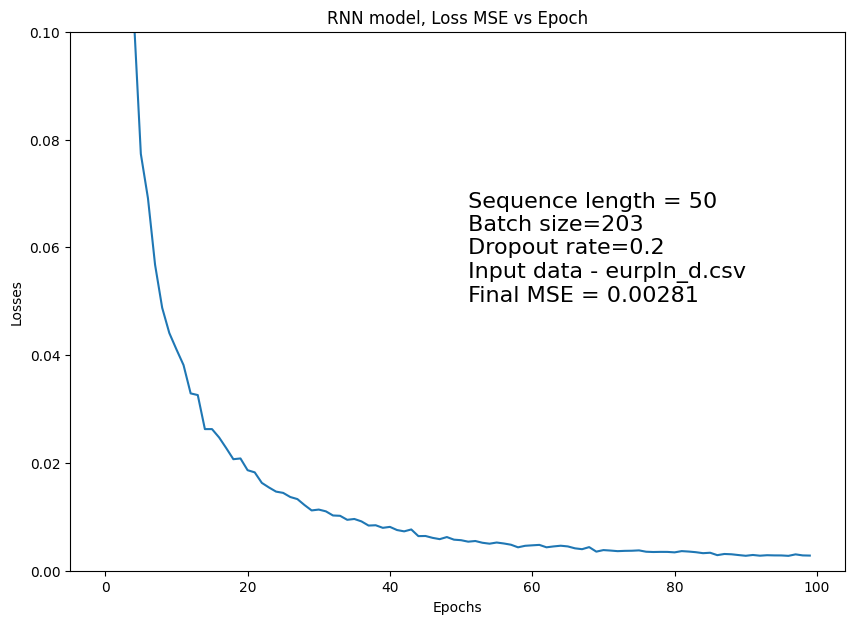

In [46]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("RNN model, Loss MSE vs Epoch")
plt.ylim(0, 0.1)  # Ustawienie zakresu osi y od 0 do 0.1
mid_x = len(history.history["loss"]) / 2  # Środek osi x (liczba epok podzielona przez 2)
mid_y = 0.05  # Środek osi y (0.05 to połowa zakresu od 0 do 0.1)
plt.text(mid_x, mid_y, f' Sequence length = {seq_length} \n Batch size={batch_size} \n Dropout rate={Dropout_rate} \n Input data - {input_data} \n Final MSE = {round(history.history["loss"][-1],5)}', fontsize=16, ha='left')# Dodanie tekstu na środku obrazka
plt.savefig(f'history_{model_name}.png')
plt.show()

64/64 [==============================] - 1s 8ms/step


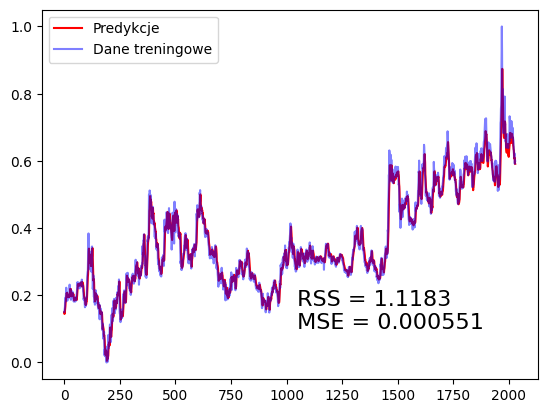

In [47]:
# Przewidywania na danych treningowych
predictions_train = model.predict(X_train)
# wykres
plt.plot(predictions_train.flatten(), color='red', label='Predykcje')
plt.plot(y_train.flatten(), color='blue', label='Dane treningowe',alpha=0.5)
plt.legend()
mid_x = len(predictions_train) / 2  # Środek osi x (liczba epok podzielona przez 2)
mid_y = 1/10  # Środek osi y (0.05 to połowa zakresu od 0 do 0.1)
#Residual Sum of Squares
plt.text(mid_x, mid_y, f' RSS = {round(np.sum((predictions_train.flatten() - y_train.flatten()) ** 2),4)} \n MSE = {round(np.mean((predictions_train.flatten() - y_train.flatten()) ** 2),6)} ', fontsize=16, ha='left')# Dodanie tekstu na środku obrazka
plt.savefig(f'pred_train_{model_name}.png')
plt.show()

16/16 [==============================] - 0s 8ms/step


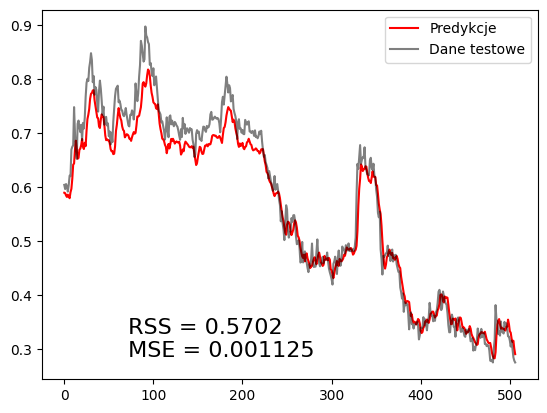

In [48]:
# Przewidywania na danych testowch
predictions_test = model.predict(X_test)
# wykres
plt.plot(predictions_test.flatten(), color='red', label='Predykcje',alpha=1)
plt.plot(y_test.flatten(), color='black', label='Dane testowe',alpha=0.5)
plt.legend()
mid_x = len(predictions_test) / 8  # Środek osi x (liczba epok podzielona przez 2)
mid_y = 10/35  # Środek osi y (0.05 to połowa zakresu od 0 do 0.1)
#Residual Sum of Squares
plt.text(mid_x, mid_y, f' RSS = {round(np.sum((predictions_test.flatten() - y_test.flatten()) ** 2),4)} \n MSE = {round(np.mean((predictions_test.flatten() - y_test.flatten()) ** 2),6)} ', fontsize=16, ha='left')# Dodanie tekstu na środku obrazka
plt.savefig(f'pred_test_{model_name}.png')
plt.show()

In [49]:
# export modelu RNN
model.save(f"keras_{model_name}.keras")

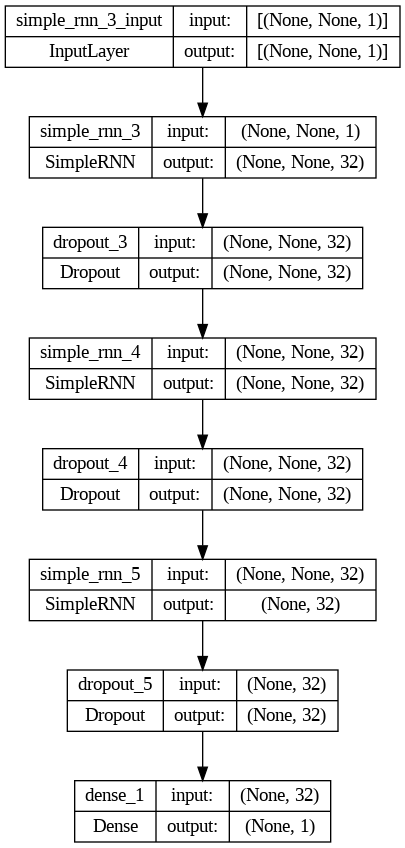

In [50]:
# Wizualizacja modelu
from keras.utils import plot_model
plot_model(model, to_file=f'architecture_{model_name}.png', show_shapes=True, show_layer_names=True)